In [34]:
from xgboost import XGBClassifier

In [1]:
from pprint import pprint
from tqdm import tqdm
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import unique_labels

pd.set_option('display.max_colwidth', None)

# Loading data

In [2]:
questions = pd.read_csv("./data/data.csv", delimiter=";")
answers = pd.read_csv("./data/train.csv", delimiter=";")

In [3]:
data = pd.merge(questions, answers, on="ID")

In [4]:
data["Question"] = data["Question"].astype("string")

# Analyzing data

In [5]:
print(data.shape)

(30000, 3)


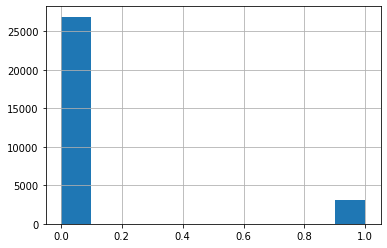

In [6]:
plt.grid(True)
plt.hist(data["Answer"])
plt.show()

In [7]:
display(data[data["Answer"] == 1].iloc[:10])

,ID,Question,Answer
1,2,Как в химии обозначается свинец?,1
5,6,Какая эра геологической истории Земли относится к настоящему времени?,1
8,9,Какой из этих мультфильмов повествует о реально существовавшей собаке?,1
20,21,"Как называется часть речи, обладающая свойствами глагола и прилагательного?",1
22,23,Когда была запущена «Википедия»?,1
41,42,Где находится яд у кобры?,1
45,46,Как зовут создателя паровой машины?,1
48,49,Сколько всего пальцев на лапах у кошек?,1
63,64,Сколько всего было выпущено серий сериала «Санта-Барбара»?,1
64,65,В каком году был поход Руси на Константинополь?,1


In [8]:
display(data[data["Answer"] == 0].iloc[:10])

,ID,Question,Answer
0,1,Как зовут лодочника на реке Стикс в древнегреческой мифологии?,0
2,3,Какой химический элемент преобладает в составе каменного угля?,0
3,4,Кто из перечисленных был пажом во времена Екатерины II?,0
4,5,Когда началась 2 мировая война?,0
6,7,Кто из животных может мурлыкать?,0
7,8,Что из перечисленного НЕ входит в национальную русскую кухню?,0
9,10,Кто написал повесть «Муму»,0
10,11,Что такое кульверт?,0
11,12,В какой воде меньше содержание примесей?,0
12,13,Сколько музыкантов в квинтете,0


In [9]:
X = data["Question"].to_numpy()
y = data["Answer"].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Solving task

In [11]:
cv=3
scoring=["accuracy", "roc_auc"]
refit="roc_auc"

In [12]:
results = {}
metrics = ["mean_test_" + score for score in scoring]

In [13]:
def get_results(gs):
    global results
    name = "__".join([step[0] for step in gs.estimator.steps])
    results[name] = {metric: round(gs.cv_results_[metric][gs.best_index_], 3) for metric in metrics}
    results[name] = results[name] | {"best_params": gs.best_params_}
    pprint(results[name])

In [14]:
def text_preprocess(x):
    #x = x[0]
    x = x.lower()
    x = re.sub(r'https*\S+', ' ', x)                           # mentions
    x = re.sub(r'@\S+', ' ', x)                                # links
    x = re.sub(r'#\S+', ' ', x)                                # hashtags
    x = re.sub(r'\'\w+', '', x)                                # ticks and the next character
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x) # punctuation
    x = re.sub(r'\w*\d+\w*', '', x)                            # numbers
    x = re.sub(r'\s{2,}', ' ', x)                              # over spaces
    x = x.replace('\xad', '')                                  # \xad
    x = x.replace('\t', '')                                    # \t
    x = x.replace('№', '')                                     # \t
    return x

In [15]:
tfidfvectorizer__param_grid = {
    #"tfidfvectorizer__ngram_range": [(1, n) for n in range(1, 5)],
    "tfidfvectorizer__ngram_range": [(1, 5)],
    "tfidfvectorizer__analyzer": ["char"],
    #"tfidfvectorizer__max_features": [None, 100, 1000, 5000, 10000],
    "tfidfvectorizer__max_features": [1000],
    #"tfidfvectorizer__preprocessor": [text_preprocess, None]
    "tfidfvectorizer__preprocessor": [None]
}

## TfidfVectorizer -> MostCommonClassifier

In [16]:
class MostCommonClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self
    
    def decision_function(self, X):

        res = [0] * X.shape[0]
        
        return np.array(res)

    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)

In [17]:
pipeline = make_pipeline(TfidfVectorizer(), MostCommonClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [18]:
gs.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('mostcommonclassifier',
                                        MostCommonClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [19]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.896, 'mean_test_roc_auc': 0.5}


## TfidfVectorizer -> ProbabilityClassifier

In [20]:
class ProbabilityClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self

    def decision_function(self, X):

        res = []
        for row in X:
            res.append(np.random.choice(list(self.probabilities.keys()), p=list(self.probabilities.values())))
        
        return np.array(res)
    
    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)

In [21]:
pipeline = make_pipeline(TfidfVectorizer(), ProbabilityClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [22]:
gs.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('probabilityclassifier',
                                        ProbabilityClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [23]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.81, 'mean_test_roc_auc': 0.502}


## TfidfVectorizer -> LogisticRegression

In [75]:
pipeline = make_pipeline(TfidfVectorizer(),
                         LogisticRegression())

logisticregression__param_grid = {
    "logisticregression__class_weight": [None, "balanced"]
}

param_grid = tfidfvectorizer__param_grid | logisticregression__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [76]:
gs.fit(X, y)

/home/furiousteabag/.local/share/virtualenvs/base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__class_weight': [None, 'balanced'],
                         'tfidfvectorizer__analyzer': ['char'],
                         'tfidfvectorizer__max_features': [1000],
                         'tfidfvectorizer__ngram_range': [(1, 5)],
                         'tfidfvectorizer__preprocessor': [None]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'])

In [77]:
get_results(gs)

{'best_params': {'logisticregression__class_weight': 'balanced',
                 'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 5),
                 'tfidfvectorizer__preprocessor': None},
 'mean_test_accuracy': 0.684,
 'mean_test_roc_auc': 0.746}


## TfidfVectorizer -> GradientBoostingClassifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

In [46]:
pipeline = make_pipeline(TfidfVectorizer(),
                         GradientBoostingClassifier())


param_grid = tfidfvectorizer__param_grid 

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1, verbose=10)

In [47]:
gs.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__analyzer': ['char'],
                         'tfidfvectorizer__max_features': [1000],
                         'tfidfvectorizer__ngram_range': [(1, 5)],
                         'tfidfvectorizer__preprocessor': [None]},
             refit='roc_auc', scoring=['accuracy', 'roc_auc'], verbose=10)

In [48]:
get_results(gs)

{'best_params': {'tfidfvectorizer__analyzer': 'char',
                 'tfidfvectorizer__max_features': 1000,
                 'tfidfvectorizer__ngram_range': (1, 5),
                 'tfidfvectorizer__preprocessor': None},
 'mean_test_accuracy': 0.896,
 'mean_test_roc_auc': 0.767}


# Results

In [49]:
info = pd.DataFrame.from_dict(results, orient="index").sort_values(by="mean_test_roc_auc", ascending=False)
display(info)

,mean_test_accuracy,mean_test_roc_auc,best_params
tfidfvectorizer__gradientboostingclassifier,0.896,0.767,"{'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 5), 'tfidfvectorizer__preprocessor': None}"
tfidfvectorizer__xgbclassifier,0.884,0.744,"{'tfidfvectorizer__analyzer': 'char', 'tfidfvectorizer__max_features': 1000, 'tfidfvectorizer__ngram_range': (1, 5), 'tfidfvectorizer__preprocessor': None}"
tfidfvectorizer__probabilityclassifier,0.810,0.502,{}
tfidfvectorizer__mostcommonclassifier,0.896,0.500,{}


# Uploading solution

## Docker packing

## Prediction

In [80]:
questions = pd.read_csv("./data/data.csv", delimiter=";")
test = pd.read_csv("./data/test.csv", delimiter=";")
data = pd.merge(questions, test, on="ID")

In [81]:
prediction = gs.predict_proba(list(data["Question"]))[:, 1]
data["prediction"] = prediction

In [82]:
data

,ID,Question,prediction
0,30001,"Что в литературе обозначает слово ""эпитет""?",0.019877
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА,0.140509
2,30003,Кто из этих бодибилдеров играл Халка,0.345797
3,30004,"Последняя на данный момент страна, официально происоединившаяся к Европейскому союзу",0.327493
4,30005,Как зовут лютоволка Арьи Старк из сериала «Игра престолов»?,0.846175
...,...,...,...
11082,41083,В каком году распался СССР,0.391766
11083,41084,Сколько калорий в 100 гр арбуза?,0.282248
11084,41085,"Сколько хвостов у лиса, который является демоном из японской мифологии?",0.577866
11085,41086,Сколько раз магнитогорский металлург становился обладателем кубка гагарина,0.352210


In [83]:
data[["ID", "prediction"]].to_csv("./output/tfidfvectorizer__logisticregression.csv", index=False, header=False)

## Preprocessing

In [53]:
questions = pd.read_csv("./data/data.csv", delimiter=";")
test = pd.read_csv("./data/test.csv", delimiter=";")
data = pd.merge(questions, test, on="ID")

In [59]:
data

,ID,Question
0,30001,"Что в литературе обозначает слово ""эпитет""?"
1,30002,Когда отмечается ДЕНЬ ШОКОЛАДА
2,30003,Кто из этих бодибилдеров играл Халка
3,30004,"Последняя на данный момент страна, официально происоединившаяся к Европейскому союзу"
4,30005,Как зовут лютоволка Арьи Старк из сериала «Игра престолов»?
...,...,...
11082,41083,В каком году распался СССР
11083,41084,Сколько калорий в 100 гр арбуза?
11084,41085,"Сколько хвостов у лиса, который является демоном из японской мифологии?"
11085,41086,Сколько раз магнитогорский металлург становился обладателем кубка гагарина


In [56]:
import numpy as np
import pandas as pd

import re, nltk

from tqdm import tqdm


def get_preprocess_data(data):
    """
    Args: 
        data - dataframe with columns [id, questions]
    """

    X = pd.DataFrame(data)
    no_expert_words = ['почему', 'будет', 'клевер', 'назовите', 'клевера', 'нельзя', 'нет', 'то', 'метро']
    regex_tokenizer = nltk.RegexpTokenizer("\w+")
    
    def normalize_text(text):
        # lowercase text
        text = str(text).lower()
        # remove non-UTF
        text = text.encode("utf-8", "ignore").decode()
        # remove punktuation symbols
        text = " ".join(regex_tokenizer.tokenize(text))
        return text
    
    questions = X.iloc[:, 1]
    vals = questions.values
    
    end_question = []
    fst_capital = []
    no_expert_eto = []
    special_signs = []
    good_special_words= []
    not_enough_words = []
    no_expert = []
    bad_comma = []
    letters=[]
    
    for i in tqdm(range(len(vals))):
        x = vals[i]
        end_question.append(int(bool(re.search(r'.*?\?$', x))))
        fst_capital.append(int(bool(re.search(r'^[А-Я]', x))))
        no_expert_eto.append(int(bool(re.search(r'(\- это|[^\–] это)[^а-яА-Я]', x))))
        special_signs.append(int(bool(re.search(r'([\'?_:$!%^&*+\"”<>]|\.{1,}|,{2,}).*?\?$', x))))
        good_special_words.append(int(bool(re.search(r'[а-яА-Яa-zA-Z]\.|\'[а-яА-Яa-zA-Z]|[a-zA-Z]+:\s?[a-zA-Z+|«.*»', x))))
        not_enough_words.append(int(bool(re.search(r'([а-яА-Яa-zA-Z]+[\s]?){6,}', x)))) 
        bad_comma.append(int(not bool(re.search(r'[а-яА-Яa-zA-Z]+\, [а-яА-Яa-zA-Z]+', x)))*int(',' in x))
        
        
        letters.append(int(bool(re.search(r'^[^КВИСЧГНПУМОЗДРАФЕЛБ]', x))))
        normal_x = normalize_text(x)
        no_expert.append(int(bool(any(w in normal_x.split() for w in no_expert_words[:6])))) 
     
    X['end_question'] = pd.Series(end_question)
    X['fst_capital'] = pd.Series(fst_capital)
    X['no_expert_eto'] = pd.Series(no_expert_eto)
    X['special_signs'] = pd.Series(special_signs)
    X['good_special_words'] = pd.Series(good_special_words)
    X['not_enough_words'] = pd.Series(not_enough_words)
    X['no_expert'] = pd.Series(no_expert)
    X['bad_comma'] = pd.Series(bad_comma)
    X['letters'] = pd.Series(letters)
    
    X.drop(X[X['end_question'] == 0].index, inplace=True)
    
    #X.drop(X[X['letters'] == 1].index, inplace=True)
    
    X.drop(X[X['fst_capital'] == 0].index, inplace=True)
    X.drop(X[(X['special_signs'] == 1) & (X['good_special_words'] == 0)].index, inplace=True)
    X.drop(X[X['bad_comma'] == 1].index, inplace=True)
    X.drop(X[X['no_expert_eto'] == 1].index, inplace=True)
    X.drop(X[X['not_enough_words'] == 0].index, inplace=True)
    X.drop(X[X['no_expert'] == 1].index, inplace=True)
    
    #X['Question'] = list(map(normalize_text, X['Question']))
    non_labeled_data = X[['ID', 'Question']]
    
    labeled_data = data[~data['ID'].isin(non_labeled_data['ID'])][['ID', 'Question']]
    labeled_data['Answer'] = list(map(int, np.zeros(labeled_data.shape[0])))

    return non_labeled_data, labeled_data
    

In [60]:
non_labeled_data, labeled_data = get_preprocess_data(data)

100%|██████████| 11087/11087 [00:00<00:00, 29231.90it/s]


In [63]:
prediction = gs.predict_proba(list(non_labeled_data["Question"]))[:, 1]
non_labeled_data["prediction"] = prediction

In [72]:
non_labeled_data["Answer"] = non_labeled_data["prediction"]

In [73]:
res = non_labeled_data.append(labeled_data).sort_values(by="ID")
res[["ID", "Answer"]].to_csv("./output/custom.csv", index=False, header=False)